In [1]:
from __future__ import absolute_import

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import architectures
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F


# Plotting MNIST Knockoff attacks

In [2]:
random_mnist_acc_path = '../random-extract/adaptive-model/mnist/MnistNetPate/1-models/random/log_raw_acc_PATE_cost_random.txt'
random_mnist_acc = pd.read_csv(random_mnist_acc_path)

In [3]:
knockoff_mnist_acc_path = '../model-extraction-iclr/adaptive-model/mnist_imagenet/MnistNetPate/1-models/knockoff/log_raw_acc_PATE_cost_knockoff.txt'
knockoff_mnist_acc = pd.read_csv(knockoff_mnist_acc_path)

Text(0, 0.5, 'Stolen Model Accuracy')

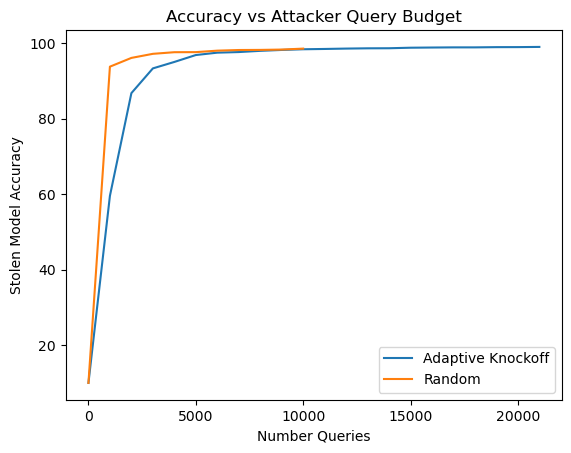

In [4]:
plt.plot(knockoff_mnist_acc['queries'], knockoff_mnist_acc['accuracy'], label='Adaptive Knockoff')
plt.plot(random_mnist_acc['queries'], random_mnist_acc['accuracy'], label='Random')
plt.legend()
plt.title("Accuracy vs Attacker Query Budget")
plt.xlabel('Number Queries')
plt.ylabel('Stolen Model Accuracy')

## Loading MNIST models and seeing differences.

In [18]:
rand_victim = '../random-extract/private-models/mnist/MnistNetPate/1-models/checkpoint-model(1).pth.tar'
rchpt = torch.load(rand_victim)

In [33]:
rchpt

{<metric.loss: 'loss'>: 0.022019824577399875,
 <metric.acc: 'acc'>: 99.39,
 <metric.acc2: 'acc2'>: 0,
 <metric.balanced_acc: 'balanced_acc'>: 0.9937885783364262,
 <metric.auc: 'auc'>: 0.9999724645522386,
 <metric.acc_detailed: 'acc_detailed'>: array([ 99.69387755, 100.        ,  99.32170543,  99.6039604 ,
         99.18533605,  99.10313901,  99.16492693,  99.12451362,
         99.38398357,  99.20713578]),
 <metric.map: 'map'>: 98.98268877973408,
 'model_name': 'model(1)',
 'state_dict': OrderedDict([('conv1.weight',
               tensor([[[[ 2.4323e-01,  3.9082e-01,  5.1187e-02, -7.6785e-02,  1.0349e-01],
                         [ 1.4373e-02,  4.1611e-01,  3.3825e-01,  1.6365e-01,  3.7647e-02],
                         [-4.3738e-01, -9.0039e-02,  2.4058e-01,  9.4431e-02,  1.7078e-02],
                         [-4.7071e-01, -5.1028e-01, -3.4941e-01, -1.6723e-01, -2.4867e-02],
                         [ 6.5463e-02, -2.7791e-03, -5.6921e-02, -1.4411e-01, -7.5567e-03]]],
               


In [69]:
device = torch.device("cuda")
rvic_model = architectures.mnist_net_pate.MnistNetPate('model(1)', [])
rvic_model.load_state_dict(rchpt['state_dict'])
rvic_model.eval()

MnistNetPate(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [85]:
transformations = []
transformations.append(transforms.ToTensor())
transformations.append(
transforms.Normalize((0.13251461,), (0.31048025,)))
transformations = transforms.Compose(transformations)

mnist_dataset = datasets.MNIST(
        root='../random-extract/MNIST/',
        train=False,
        transform=transformations,
        download=False)

mnist_test_loader = torch.utils.data.DataLoader(mnist_dataset, 
                              batch_size=50, 
                              shuffle=True, 
                              num_workers=1)

In [104]:
from scipy.stats import wasserstein_distance
from scipy.stats import entropy

## Some relatively interesing stats 

In [115]:
test_losses = []
test_losses2 = []
test_loss = 0
test_loss2 = 0
correct = 0
correct2 = 0
wasses = []
entrs = []
with torch.no_grad():
    for batch_idx, (test_data, test_targets) in enumerate(mnist_test_loader):
        output = rvic_model(test_data)
        output2 = knock_model(test_data)
        for i in range(output.numpy().shape[0]):
            wass = wasserstein_distance(output.numpy()[i,:], output2.numpy()[i, :])
            wasses.append(wass)
            entr = entropy(abs(output2.numpy()[i, :]), abs(output.numpy()[i,:]))
            entrs.append(entr)
        test_loss += F.cross_entropy(output, test_targets, size_average=False).item()
        test_loss2 += F.cross_entropy(output2, test_targets, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        pred2 = output2.data.max(1, keepdim=True)[1]
        correct += pred.eq(test_targets.data.view_as(pred)).sum()
        correct2 += pred2.eq(test_targets.data.view_as(pred2)).sum()

    test_loss /= len(mnist_test_loader.dataset)
    test_loss2 /= len(mnist_test_loader.dataset)
    test_losses.append(test_loss)
    test_losses2.append(test_loss2)
    print('\nVictim Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
                                test_loss, correct, len(mnist_test_loader.dataset),
                                100. * correct / len(mnist_test_loader.dataset)))
    print('\nKnockoff Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
                                test_loss2, correct2, len(mnist_test_loader.dataset),
                                100. * correct2 / len(mnist_test_loader.dataset)))
    print('Mean wasserstein distance: {} +- {}'.format(np.mean(wasses), np.std(wasses)))
    print('Mean KL: {} +- {}'.format(np.mean(entrs), np.std(entrs)))


Victim Test set: Avg. loss: 0.0221, Accuracy: 9939/10000 (99.3900%)


Knockoff Test set: Avg. loss: 0.0327, Accuracy: 9895/10000 (98.9500%)

Mean wasserstein distance: 1.571304215996233 +- 0.5380780787085179
Mean KL: 0.12261580675840378 +- 0.0876065194606781


In [74]:
knockoff_stolen = '../model-extraction-iclr/adaptive-model/mnist_imagenet/MnistNetPate/1-models/knockoff/checkpoint.pth.tar'
chpt = torch.load(knockoff_stolen)
knock_model = architectures.mnist_net_pate.MnistNetPate('knockoff', [])
knock_model.load_state_dict(chpt['state_dict'])
knock_model.eval()

MnistNetPate(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)